# LANL dataset stats

This notebook explores the data from the LANL database

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [ ]:
from datasets.LANL_local import LANLL
from ordered_set import OrderedSet

dataset = LANLL("/data/datasets/LANL")

dataset.prepare_data()
dataset.setup(stage="fit")

### Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Get dataset columns
columns = list(next(iter(dataset.generate_bins())).columns)

# Generate keymaps
exclude_columns = [
    "time",
    "source computer",
    "destination computer",
    "source user@domain",
    "destination user@domain"
]
keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
hostmap = OrderedSet([])
usermap = OrderedSet([])

# Keep track of the added values per column
added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
added_items_per_bin["hosts"] = []
added_items_per_bin["services"] = []

def count_updates(ordered_set: OrderedSet, update):
    set_size = len(ordered_set)
    ordered_set.update(update)
    new_size = len(ordered_set)
    return new_size

def show_plot(df: pd.DataFrame):
    clear_output(wait=True)
    ax = df[["hosts"]].plot(xlabel="bin", ylabel="Unique count")
    plt.grid(True)
    plt.show()

for batch_id, (batch, stage) in enumerate(dataset.generate_batches()):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
        diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
        diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

    df = pd.DataFrame(added_items_per_bin)
    show_plot(df)


df = pd.DataFrame(added_items_per_bin)
show_plot(df)
df.to_parquet("keywordmap_percent.parquet")

### Graph unique (unseen) values v2
The same graph is also observed per stage, assuming the data is fed to the algorithm in the following sequence: 'train', 'validation', 'test'.

<Figure size 1000x500 with 0 Axes>

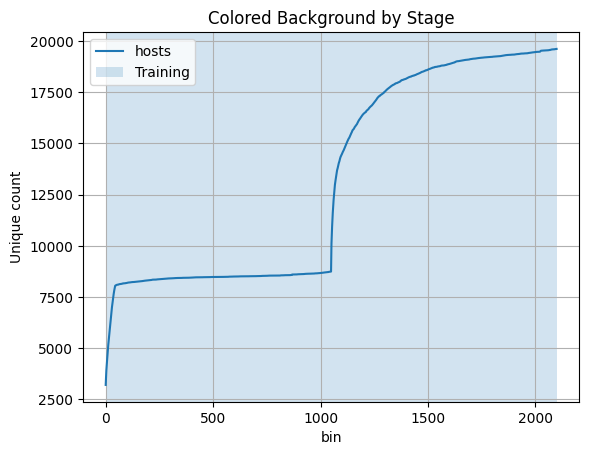

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Get dataset columns
columns = list(next(iter(dataset.generate_bins())).columns)

# Generate keymaps
exclude_columns = [
    "time",
    "source computer",
    "destination computer",
    "source user@domain",
    "destination user@domain"
]
keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
hostmap = OrderedSet([])
usermap = OrderedSet([])

# Keep track of the added values per column
added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
added_items_per_bin["hosts"] = []
added_items_per_bin["services"] = []
added_items_per_bin["stage"] = []

def count_updates(ordered_set: OrderedSet, update):
    set_size = len(ordered_set)
    ordered_set.update(update)
    new_size = len(ordered_set)
    return new_size

def show_plot(df: pd.DataFrame):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    # Plot the data
    ax = df[["hosts"]].plot(xlabel="bin", ylabel="Unique count")

    # Get unique stages and their x ranges
    for stage, group in df.groupby("stage"):
        x_start = group.index.min()
        x_end = group.index.max()

        stage_label = "Training"
        if stage == 1:
            stage_label = "Validation"
        if stage == 2:
            stage_label = "Testing"

        plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label)

    plt.title("Colored Background by Stage")
    plt.legend()
    plt.grid(True)
    plt.show()

for batch_id, (batch, stage) in enumerate(dataset.generate_batches(0)):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
        diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
        diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

        added_items_per_bin["stage"].append(stage)

    df = pd.DataFrame(added_items_per_bin)
    show_plot(df)

for batch_id, (batch, stage) in enumerate(dataset.generate_batches(1)):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
        diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
        diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

        added_items_per_bin["stage"].append(stage)

    df = pd.DataFrame(added_items_per_bin)
    show_plot(df)

for batch_id, (batch, stage) in enumerate(dataset.generate_batches(2)):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
        diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
        diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

        added_items_per_bin["stage"].append(stage)

    df = pd.DataFrame(added_items_per_bin)
    show_plot(df)


df = pd.DataFrame(added_items_per_bin)
show_plot(df)
df.to_parquet("keywordmap_percentv2.parquet")

### Dataset stats

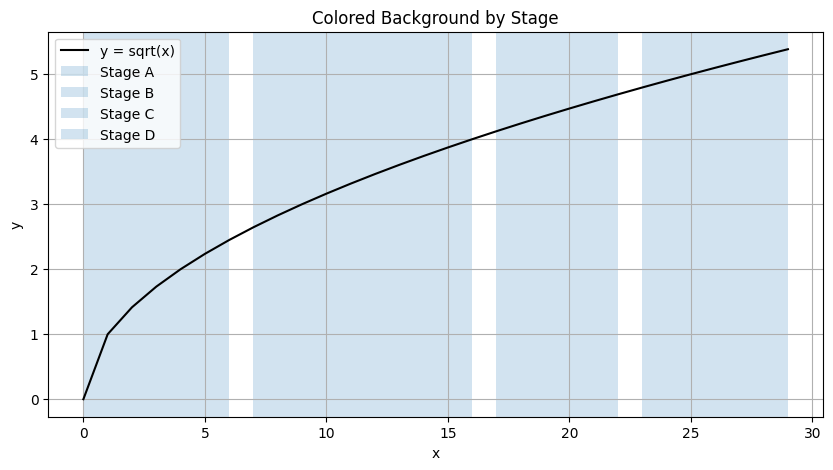

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = pd.DataFrame({
    "x": list(range(30)),
    "y": [i ** 0.5 for i in range(30)],
    "stage": ["A"] * 7 + ["B"] * 10 + ["C"] * 6 + ["D"] * 7
})

plt.figure(figsize=(10, 5))

# Plot the data
plt.plot(df["x"], df["y"], color='black', label='y = sqrt(x)', zorder=10)

# Get unique stages and their x ranges
for stage, group in df.groupby("stage"):
    x_start = group["x"].min()
    x_end = group["x"].max()
    plt.axvspan(x_start, x_end, alpha=0.2, label=f"Stage {stage}")

plt.title("Colored Background by Stage")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()